In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import acquire
import wrangle
import model

In [2]:
df = acquire.get_telco_data()

In [3]:
df = wrangle.wrangle_telco()

In [4]:
df.head(70)

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,monthly_charges_scaled,tenure_3_or_less
0,0002-ORFBO,Female,0,Yes,Yes,9,65.60,593.30,Yes,No,...,Yes,No,Yes,2,2,1,No,False,0.471144,False
1,0003-MKNFE,Male,0,No,No,9,59.90,542.40,Yes,Yes,...,No,Yes,No,1,2,1,No,False,0.414428,False
2,0004-TLHLJ,Male,0,No,No,4,73.90,280.85,Yes,No,...,No,No,Yes,1,1,2,Yes,False,0.553731,False
3,0011-IGKFF,Male,1,Yes,No,13,98.00,1237.85,Yes,No,...,Yes,Yes,Yes,1,1,2,Yes,False,0.793532,False
4,0013-EXCHZ,Female,1,Yes,No,3,83.90,267.40,Yes,No,...,Yes,No,Yes,1,2,2,Yes,False,0.653234,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0111-KLBQG,Male,1,Yes,Yes,32,93.95,2861.45,Yes,No,...,Yes,Yes,Yes,1,2,2,No,False,0.753234,False
66,0112-QAWRZ,Male,0,Yes,Yes,16,90.80,1442.20,Yes,Yes,...,Yes,No,Yes,1,3,2,No,True,0.721891,False
67,0112-QWPNC,Male,0,Yes,No,49,84.35,4059.35,Yes,Yes,...,Yes,Yes,No,2,1,1,Yes,False,0.657711,False
68,0114-IGABW,Female,0,Yes,No,71,58.25,4145.90,No,No phone service,...,Yes,Yes,No,3,3,1,No,True,0.398010,False


In [5]:
train, test = train_test_split(df, random_state=123, train_size=.80)

In [6]:
encoder = LabelEncoder()

encode_list = [
    'gender', 'partner', 'dependents', 'phone_service'
    , 'multiple_lines', 'online_security', 'online_backup'
    , 'device_protection', 'tech_support'
    , 'streaming_movies', 'streaming_tv', 'paperless_billing', 'churn'
    ]
               
               
               
for e in encode_list:
    train[e] = encoder.fit_transform(train[e])
    test[e] = encoder.transform(test[e])

# Optimize for recall
- because we really don't want to miss positive cases

## Logit classifier with tenure 3 or less

In [7]:
train, validate = train_test_split(train, random_state=123, test_size=.2)


X_train = train[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_train = train[['churn']]
X_val = validate[['contract_type_id', 'senior_citizen', 'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_val = validate[['churn']]
X_test = test[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled', 'payment_type_id']]
y_test = test[['churn']]

In [8]:
logit = LogisticRegression(random_state = 123)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
y_pred = logit.predict(X_val)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [10]:
confusion_matrix(y_val, y_pred)

array([[756,  70],
       [164, 137]])

In [11]:
train.churn.value_counts()

0    3316
1    1191
Name: churn, dtype: int64

In [12]:
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit.score(X_val, y_val)))

Accuracy of Logistic Regression classifier on validate set: 0.79


In [13]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       826
           1       0.66      0.46      0.54       301

    accuracy                           0.79      1127
   macro avg       0.74      0.69      0.70      1127
weighted avg       0.78      0.79      0.78      1127



### Test Set

In [14]:
y_pred2 = logit.predict(X_test)
y_pred2[:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [15]:
confusion_matrix(y_test, y_pred2)

array([[933,  99],
       [207, 170]])

In [16]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.78


In [17]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1032
           1       0.63      0.45      0.53       377

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



# Decision Tree with best features

In [18]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)

In [19]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [20]:
y_pred = clf.predict(X_val)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [21]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_val, y_val)))

Accuracy of Decision Tree classifier on validate set: 0.77


In [22]:
confusion_matrix(y_val, y_pred)

array([[806,  20],
       [243,  58]])

In [23]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       826
           1       0.74      0.19      0.31       301

    accuracy                           0.77      1127
   macro avg       0.76      0.58      0.58      1127
weighted avg       0.76      0.77      0.71      1127



### Test set

In [24]:
y_pred1 = clf.predict(X_test)
y_pred1[0:5]

array([0, 0, 0, 1, 0])

In [25]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.77


In [26]:
confusion_matrix(y_test, y_pred1)

array([[1003,   29],
       [ 300,   77]])

In [27]:
target_names = ["did not churn", "churn"]
print(classification_report(y_test, y_pred1, target_names = target_names))

               precision    recall  f1-score   support

did not churn       0.77      0.97      0.86      1032
        churn       0.73      0.20      0.32       377

     accuracy                           0.77      1409
    macro avg       0.75      0.59      0.59      1409
 weighted avg       0.76      0.77      0.71      1409



Create a dataframe with all the model predictions

In [28]:
model_df = test[['churn']]

In [29]:
model_df = model_df.rename(columns={"churn": "actual"})

In [30]:
model_df.head()

,actual
941,0
1404,0
5515,0
3684,1
7017,0


In [31]:
# Programmatically assign the value of the most frequent 
model_df["baseline"] = model_df.actual.value_counts().index[0]
model_df.head()

,actual,baseline
941,0,0
1404,0,0
5515,0,0
3684,1,0
7017,0,0


In [32]:
model_df["Logit_Classifier"] = logit.predict(X_test)

In [33]:
model_df

,actual,baseline,Logit_Classifier
941,0,0,0
1404,0,0,0
5515,0,0,0
3684,1,0,1
7017,0,0,1
...,...,...,...
2464,0,0,0
5585,1,0,0
804,0,0,0
3190,0,0,0


In [34]:
model_df["Decision_Tree"] = clf.predict(X_test)

In [35]:
model_df

,actual,baseline,Logit_Classifier,Decision_Tree
941,0,0,0,0
1404,0,0,0,0
5515,0,0,0,0
3684,1,0,1,1
7017,0,0,1,0
...,...,...,...,...
2464,0,0,0,0
5585,1,0,0,0
804,0,0,0,0
3190,0,0,0,0


In [36]:
# # Programmatically get all the model columns
# # .loc[starting_row:ending_row, starting_column:ending_column]
# def model_accuracy(df):
#     models = model_df.loc[:, "baseline":"Decision_Tree"].columns.tolist()
#     models
    
#     output = []
#     for model in models:
#         output.append({
#             "model": model,
#             "accuracy": (model_df[model] == model_df.actual).mean()
#         })
    
    
#     metrics = pd.DataFrame(output)
#     metrics = metrics.sort_values(by="accuracy", ascending=False)
#     return metrics

In [37]:
# accuracy = model.model_accuracy(model_df)

In [38]:
# # programatically create logit model
# def logit_model(train, test):
# # Create X and y variables for each dataset
#     X_train = train[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled']]
#     y_train = train[['churn']]
#     X_test = test[['contract_type_id', 'senior_citizen',  'tenure_3_or_less', 'monthly_charges_scaled']]
#     y_test = test[['churn']]
    
#     # Create and fit the model; set a random seed for reproducibility
#     logit = LogisticRegression(random_state = 123)
#     logit.fit(X_train, y_train)
    
#     # Use the model to make predictions
#     y_pred = logit.predict(X_test)
#     y_pred[:10]
    
#     # Print a classification report
#     print(classification_report(y_test, y_pred))

In [39]:
classification_report = model.logit_metrics(train, test)

               precision    recall  f1-score   support

did not churn       0.81      0.90      0.85      1032
        churn       0.61      0.43      0.50       377

     accuracy                           0.77      1409
    macro avg       0.71      0.66      0.68      1409
 weighted avg       0.76      0.77      0.76      1409



In [40]:
cr2 = model.decision_tree_metrics(train, test)

               precision    recall  f1-score   support

did not churn       0.76      0.98      0.86      1032
        churn       0.75      0.17      0.28       377

     accuracy                           0.76      1409
    macro avg       0.76      0.57      0.57      1409
 weighted avg       0.76      0.76      0.70      1409



In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
monthly_charges             7043 non-null float64
total_charges               7043 non-null float64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
contract_type_id            7043 non-null int64
payment_type

In [42]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,monthly_charges,total_charges,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,contract_type_id,payment_type_id,internet_service_type_id,churn,automatic_payment,monthly_charges_scaled,tenure_3_or_less
1249,1848-LBZHY,0,0,1,0,7,50.30,355.10,1,0,...,0,0,1,1,3,1,0,True,0.318905,False
6265,8868-WOZGU,1,0,0,0,28,105.70,2979.50,1,2,...,2,2,1,1,1,2,1,False,0.870149,False
3772,5310-NOOVA,1,0,0,0,46,19.95,907.05,1,0,...,1,1,0,3,1,3,0,False,0.016915,False
3391,4821-SJHJV,0,0,1,1,32,89.60,2901.80,1,2,...,2,0,0,1,1,2,0,False,0.709950,False
6795,9643-YBLUR,1,0,1,0,9,69.05,653.95,1,2,...,0,2,1,1,4,1,0,True,0.505473,False


In [43]:
df1=train[train.churn == 1]
df1.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'monthly_charges', 'total_charges', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'contract_type_id', 'payment_type_id',
       'internet_service_type_id', 'churn', 'automatic_payment',
       'monthly_charges_scaled', 'tenure_3_or_less'],
      dtype='object')

In [44]:
df1.groupby(['online_security','streaming_tv','streaming_movies']).online_backup.value_counts()

online_security  streaming_tv  streaming_movies  online_backup
0                0             0                 0                306
                                                 2                 79
                               2                 0                 98
                                                 2                 35
                 2             0                 0                 95
                                                 2                 27
                               2                 0                186
                                                 2                101
1                1             1                 1                 70
2                0             0                 0                 53
                                                 2                 15
                               2                 2                 11
                                                 0                 10
                 2         

In [45]:
df1.groupby(['internet_service_type_id']).online_backup.value_counts()

internet_service_type_id  online_backup
1                         0                228
                          2                 70
2                         0                581
                          2                242
3                         1                 70
Name: online_backup, dtype: int64

In [46]:
df1.internet_service_type_id.value_counts()

2    823
1    298
3     70
Name: internet_service_type_id, dtype: int64

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import logistic_regression_util

In [48]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
probs = logit.predict(X_train)
actual = y_train

In [50]:
def evaluate_thresholds(y, probs):
    return pd.DataFrame(
        [evaluate_threshold(t, y, probs) for t in np.arange(0, 1.01, 0.01)]
    )

In [51]:
def plot_metrics_by_thresholds(y, probs, subplots=False):
    evaluation = evaluate_thresholds(y, probs)
    axs = (
        evaluation.query("precision > 0")
        .set_index("threshold")
        .plot(subplots=subplots, sharex=True, sharey=True, figsize=(12, 8.5))
    )
    (axs[-1] if subplots else axs).set_xticks(np.arange(0, 1.05, 0.05))
    plt.tight_layout()

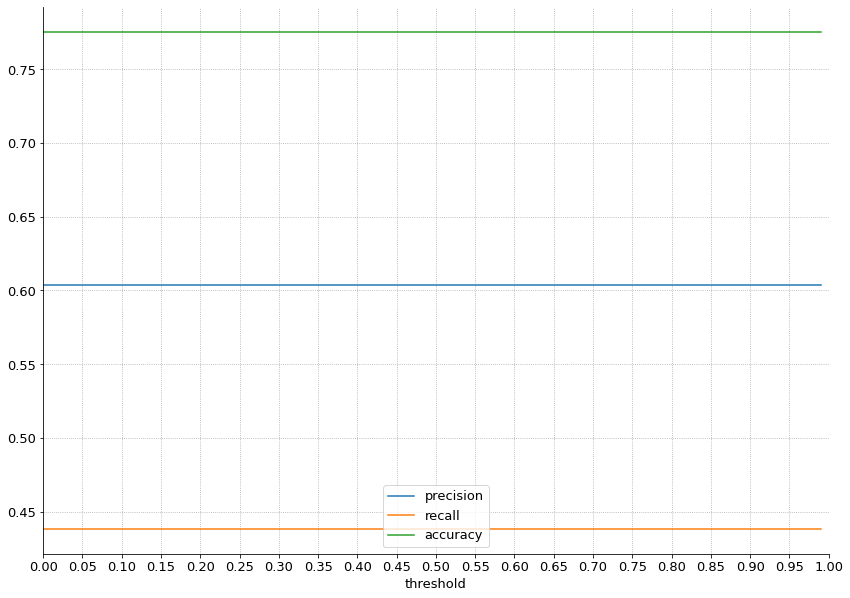

In [52]:
logistic_regression_util.plot_metrics_by_thresholds(actual, probs)

In [60]:
thresholds = logistic_regression_util.evaluate_thresholds(evaluation.actual, evaluation['survived ~ pclass + age + sex + alone'])
thresholds.sort_values(by='accuracy')

0.7828246983676366